## Forecasting of Yearly Suicide Rate in Thailand
This Notebook was used for a project in Industrial Forecasting course for more understanding in forecasting process and to compare between each forecasting method. Some of the work was done in others program (R, Minitab, Excel)

# Library

In [1]:
import numpy as np
import pandas as pd
from pandas import set_option
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import math

In [33]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.stats import stattools
from pmdarima.arima import ADFTest
from pmdarima import arima

# Preparation


In [4]:
df = pd.read_csv('suicide rate data factor.csv',header=0)
df.head()

,year,year.1,suicide rate/100k,growth rate,life expectancy,population,inflation rate,manufacturing,GDP per capita,GNI per capita,...,imports,export,poverty rate,hungers,unemployment rate,youth rate,participation rate,crime rate/100k,military,health per capita
0,2540,1997,6.92,1.19,70.27,60.50,5.63,39.75,2.47,2.68,...,1.92,1.81,44.45,16.6,1.51,2.19,59.24,7.87,3.26,62.11
1,2541,1998,8.12,1.21,70.30,61.20,7.99,30.86,1.85,2.08,...,1.77,2.25,43.90,16.8,4.37,7.58,56.66,8.71,2.11,60.90
2,2542,1999,8.59,1.16,70.48,61.80,0.28,35.69,2.03,1.98,...,1.91,2.21,47.80,16.7,4.20,8.01,53.11,8.11,2.06,63.15
3,2543,2000,8.40,1.05,70.67,61.88,1.59,35.86,2.01,1.98,...,2.49,2.77,48.60,16.3,3.60,6.83,52.92,8.17,1.88,62.26
4,2544,2001,7.74,0.93,70.85,62.31,1.63,33.47,1.89,1.96,...,2.75,2.88,44.15,17.4,3.66,7.88,53.77,7.90,1.72,57.29


In [5]:
df.drop(['year'],axis=1,inplace=True)
df.drop(['year.1'],axis=1,inplace=True)

We can see that the dataset is very small (23 sample) because the Department of Mental Health start collecting this data in 1997.

First, let's look at the time series plot of suicide rate.

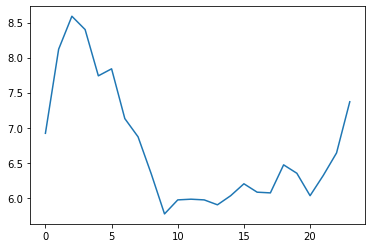

In [6]:
plt.plot(df['suicide rate/100k'])

We will first split the data for evaluation by using the last 6 years (about 25%) as test split.

In [7]:
#split train-test (not randomly because data could be correlate by time)
train=df[:18]
test=df[18:]
print('train set size:',train.shape)
print('test set size:',test.shape)

train set size: (18, 20)
test set size: (6, 20)


## Correlation
We start by looking at the correlation matrix between each feature and the target feature (suicide rate) . 

In [8]:
def plot_corr(data):
  set_option('precision', 2)
  train.corr(method='pearson')
  plt.figure(figsize=(12,10))
  cor = data.corr()
  sns.heatmap(cor, annot=True, cmap="YlGnBu")
  return cor['suicide rate/100k']

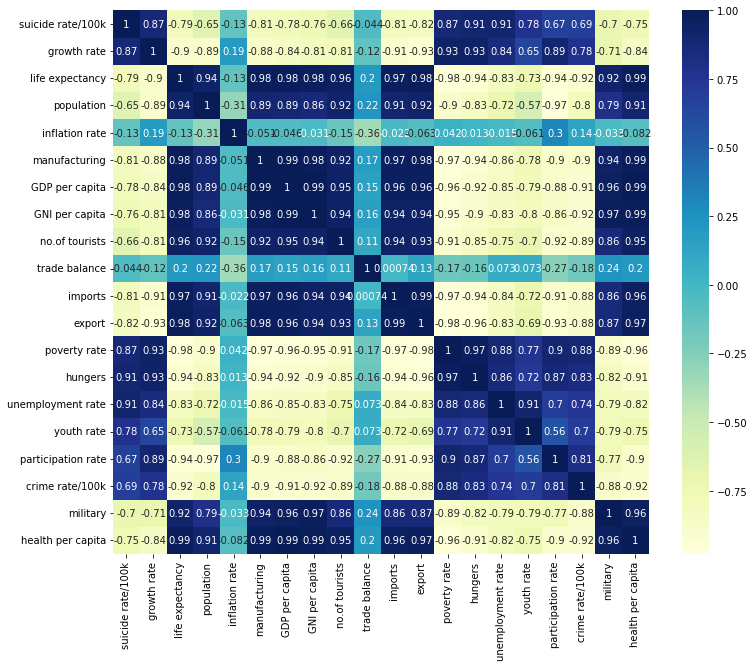

In [9]:
train_corr = plot_corr(train)

In [12]:
def high_corr(data):
  cor_target = abs(data.corr())['suicide rate/100k']
    
  #selecting only high correlation (>0.7)
  relevant_features = cor_target[cor_target>0.7]
  plot_corr(data[relevant_features.index])
  return relevant_features.index

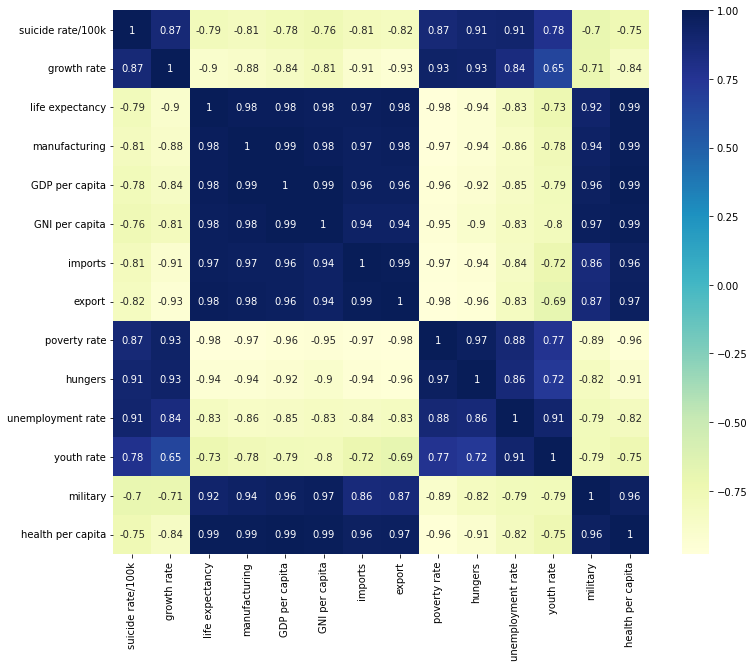

In [13]:
train_corr = high_corr(train)

In [14]:
x_train = train.drop(['suicide rate/100k'],axis=1)
y_train = train['suicide rate/100k']
x_test = test.drop(['suicide rate/100k'],axis=1)
y_test = test['suicide rate/100k']

# Single Regression

In [160]:
def fit_linear_regression(x_label):
  lm = LinearRegression()
  model = lm.fit(x_train[x_label],y_train)
  print(x_label)
  print("Coeff:",model.coef_)
  print("Intercept:",model.intercept_)

  y_tp = model.predict(x_train[x_label])
  resid = y_train-y_tp
  print("\nDurbin-Watson statistic:",stattools.durbin_watson(resid))

  y_pred = model.predict(x_test[x_label])
  print("\nr-square of train set:",model.score(x_train[x_label],y_train))

  # plot scatter plot between predicted and actual value
  plt.scatter([i for i in range(6)],y_test)
  plt.scatter([i for i in range(6)],y_pred, color='red')
  plt.ylabel('suicide rate/100k')
  plt.legend(['actual','predict'])
  plt.show()
  
  # show error of each predicted value
  error = pd.DataFrame(data=[y_test.values,y_pred,(y_test.values-y_pred)/y_test.values], index=['Y','Y_pred','%error']).T
  display(error)

  # plot the train set fitted value
  y_fit = model.predict(x_train[x_label])
  plt.plot(y_train)
  plt.plot(y_fit, color='red')
  plt.legend(['actual','fit'])
  plt.title('Multiple Regression')
  plt.show()

  # plot acf to show that there is no pattern left (EX: serial correlation, trend)
  tsaplots.plot_acf(resid,zero=False)
    
  return model

['unemployment rate']
Coeff: [0.71953937]
Intercept: 5.33345509980259

Durbin-Watson statistic: 1.3517395158713281

r-square of train set: 0.8339560782234495


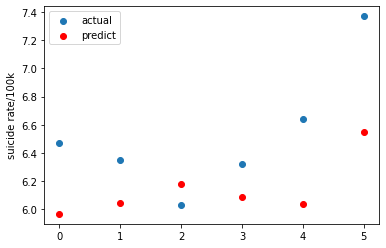

,Y,Y_pred,%error
0,6.47,5.97,0.08
1,6.35,6.05,0.05
2,6.03,6.18,-0.03
3,6.32,6.09,0.04
4,6.64,6.04,0.09
5,7.37,6.55,0.11


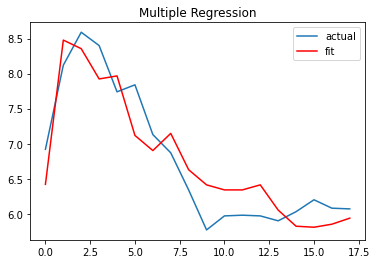

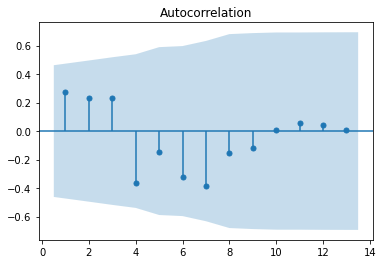

In [161]:
single_var = fit_linear_regression(['unemployment rate'])

for k=1, n=24 at alpha 0.05



du = 1.158


dl = 1.391

From dw = 1.352, Test is inconclusive.

We can solve this by incorporate more variable into the model.

# Multiple Regression


Python doesn't contain stepwise regression, so the process was done in Minitab.



Then, the remainning variable was used to create scikit-learn linear regression.




['unemployment rate', 'hungers', 'growth rate', 'participation rate']
Coeff: [ 0.24664015  0.21355161  1.71078131 -0.13557966]
Intercept: 9.12511826333405

Durbin-Watson statistic: 2.5101126265155562

r-square of train set: 0.9480697512230026


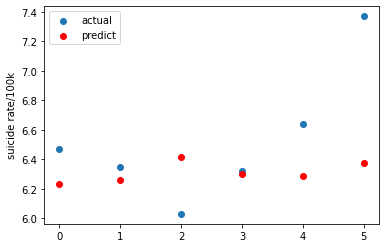

,Y,Y_pred,%error
0,6.47,6.23,3.71e-02
1,6.35,6.26,1.46e-02
2,6.03,6.42,-6.45e-02
3,6.32,6.30,3.51e-03
4,6.64,6.29,5.29e-02
5,7.37,6.37,1.35e-01


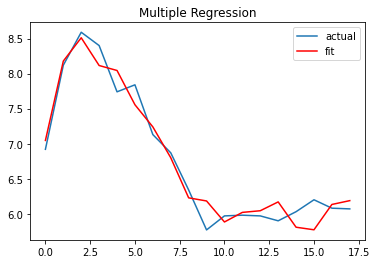

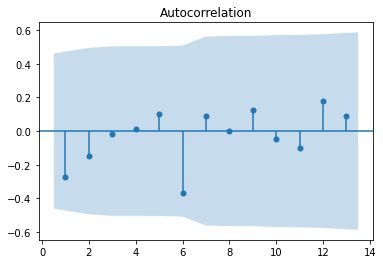

In [162]:
three_var = fit_linear_regression(['unemployment rate','hungers','growth rate','participation rate'])

for k=3, n=24 at alpha = 0.05

---

dL = 0.933

dU = 1.696


From dw = 2.510

dw>dU, meaning that we can not reject H0 (no serial correlation)



## ARIMA


In [26]:
train_ts = train['suicide rate/100k']
test_ts = test['suicide rate/100k']

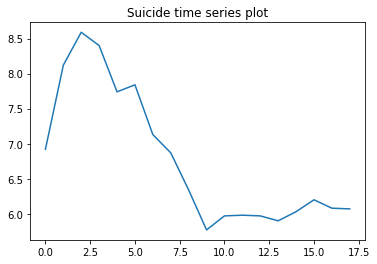

In [27]:
plt.plot(train_ts)
plt.title('Suicide time series plot')
plt.show()

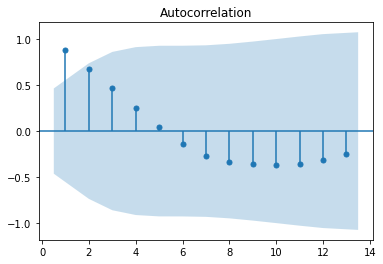

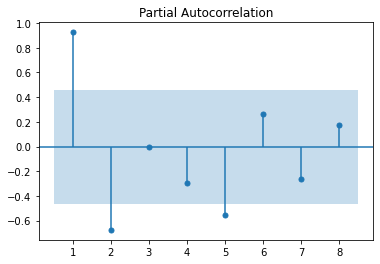

In [29]:
tsaplots.plot_acf(train_ts, zero=False)
tsaplots.plot_pacf(train_ts,zero=False,lags=8)

plt.show()

We will use Augmented Dickey Fuller test to see whether this dataset is stationary or not.

In [66]:
def diff_test(data):
  adf_test = ADFTest(alpha = 0.05)
  prob, should= adf_test.should_diff(data)
  print("This data is not stationary \nwith probability: " if should else "This data is stationary\nwith probability: ",prob)

In [67]:
diff_test(train_ts)

This data is not stationary 
with probability:  0.7965096237260079


From the time series plot and ADF test show that this dataset has some trend component in it.

However, the datasize is very small so we will treat this dataset as both stationary data and trend data.

From ACF and p-ACF we can see that this data resemble ARIMA(2,0,1) and ARIMA(2,0,2).

Next, we will try differecning to eliminate trend component.

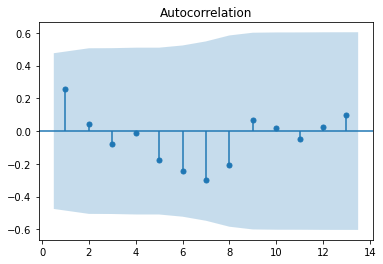

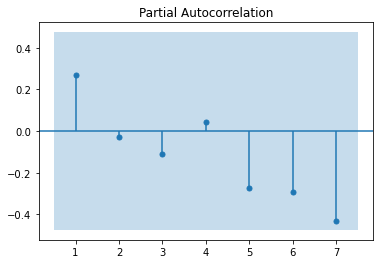

In [70]:
train_ts_diff = train_ts.diff()[1:]
tsaplots.plot_acf(train_ts_diff, zero=False)
tsaplots.plot_pacf(train_ts_diff,zero=False,lags=7)

plt.show()

From the ACF and p-ACF plot of differenced time series, the data become random so it resemble ARIMA(0,1,0) or Naive model

So, we will compare between ARIMA(1,0,0) , ARIMA(2,0,0) and ARIMA(0,1,0)

Verified our assumption with auto arima function

In [81]:
arima.auto_arima(train_ts,start_p=0, start_q=0,max_p=3,max_d=3,max_q=3,seasonal=False,trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24.798, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24.720, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25.223, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23.010, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26.716, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.116 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [84]:
arima.auto_arima(train_ts,start_p=0, d=0, start_q=0, max_p=3, max_d=3, max_q=3, seasonal=False, trace=True, information_criterion='aic')

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=122.289, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=31.770, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=33.060, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=32.737, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=34.694, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=27.617, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=38.057, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=27.938, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=24.527, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=25.550, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=26.885, Time=0.11 sec
 ARIMA(2

ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True)

In [156]:
def fit_arima(a,b,c):
    model = ARIMA(train_ts,order=(a,b,c))
    result = model.fit()
    print(result.summary())
    result_test = result.apply(test_ts)
    
    display(pd.DataFrame(data=[test_ts,result_test.predict(),(test_ts-result_test.predict())/test_ts], index=['Y','Y_pred','error']).T)
    
    #plot time series of fitted value
    plt.plot(train_ts)
    plt.plot(result.predict(), color='red')
    plt.title('ARIMA({},{},{}) of fitted value'.format(a,b,c))
    plt.legend(['actual','fit'])
    plt.show()
    
    # plot scatter plot between predicted and actual value
    plt.scatter([i for i in range(6)],test_ts)
    plt.scatter([i for i in range(6)],result_test.predict(), color='red')
    plt.ylabel('suicide rate/100k')
    plt.legend(['actual','predict'])
    plt.title('Predicted value (test set)')
    plt.show()
    
    plot_acf(result.resid)
  

def plot_acf(resid):
    tsaplots.plot_acf(resid, zero=False) 
    plt.title('Residual Autocorrelation')
    plt.show()
    
    tsaplots.plot_pacf(resid, zero=False, lags=8)
    plt.title('Residual Partial Autocorrelation')
    plt.show()

## ARIMA (2,0,1)

                               SARIMAX Results                                
Dep. Variable:      suicide rate/100k   No. Observations:                   18
Model:                 ARIMA(2, 0, 1)   Log Likelihood                  -7.255
Date:                Thu, 24 Mar 2022   AIC                             24.509
Time:                        20:17:47   BIC                             28.961
Sample:                             0   HQIC                            25.123
                                 - 18                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6086      0.341     19.371      0.000       5.940       7.277
ar.L1          1.8262      0.054     33.689      0.000       1.720       1.932
ar.L2         -0.9473      0.063    -14.949      0.0

C:\Users\n_ont\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Y,Y_pred,error
18,6.47,6.61,-0.02
19,6.35,6.49,-0.02
20,6.03,6.33,-0.05
21,6.32,5.99,0.05
22,6.64,6.39,0.04
23,7.37,6.74,0.09


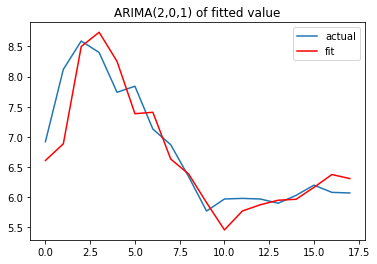

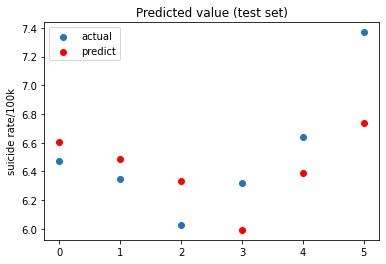

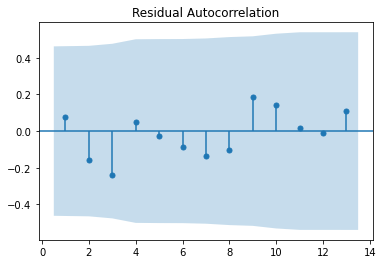

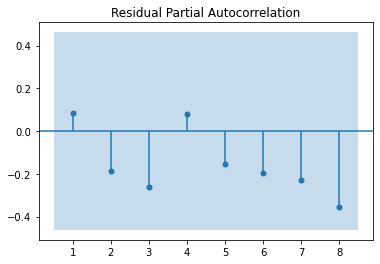

In [157]:
fit_arima(2,0,1)

## ARIMA (2,0,2)

                               SARIMAX Results                                
Dep. Variable:      suicide rate/100k   No. Observations:                   18
Model:                 ARIMA(2, 0, 2)   Log Likelihood                  -7.163
Date:                Thu, 24 Mar 2022   AIC                             26.327
Time:                        20:17:48   BIC                             31.669
Sample:                             0   HQIC                            27.063
                                 - 18                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6015      0.418     15.784      0.000       5.782       7.421
ar.L1          1.8131      0.067     27.190      0.000       1.682       1.944
ar.L2         -0.9353      0.076    -12.250      0.0

C:\Users\n_ont\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\n_ont\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Y,Y_pred,error
18,6.47,6.60,-0.02
19,6.35,6.48,-0.02
20,6.03,6.32,-0.05
21,6.32,5.98,0.05
22,6.64,6.43,0.03
23,7.37,6.76,0.08


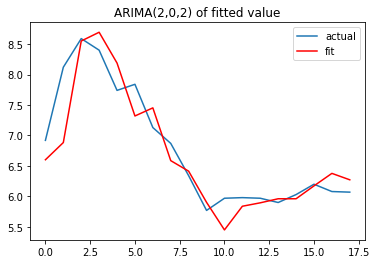

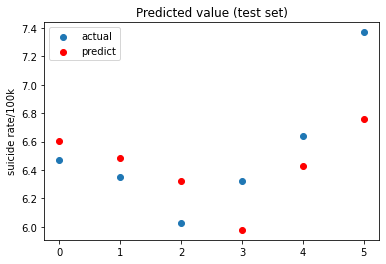

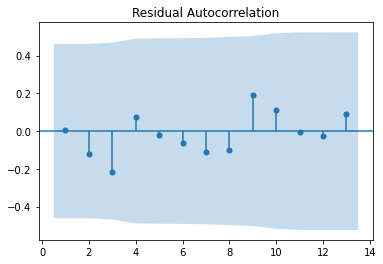

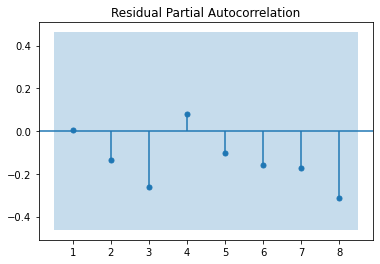

In [158]:
fit_arima(2,0,2)

# ARIMA (0,1,0)

                               SARIMAX Results                                
Dep. Variable:      suicide rate/100k   No. Observations:                   18
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -10.505
Date:                Thu, 24 Mar 2022   AIC                             23.010
Time:                        20:17:55   BIC                             23.844
Sample:                             0   HQIC                            23.093
                                 - 18                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2015      0.056      3.570      0.000       0.091       0.312
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                 3.71
Prob(Q):                              0.25   Pr

C:\Users\n_ont\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Y,Y_pred,error
18,6.47,0.00,1.00
19,6.35,6.47,-0.02
20,6.03,6.35,-0.05
21,6.32,6.03,0.05
22,6.64,6.32,0.05
23,7.37,6.64,0.10


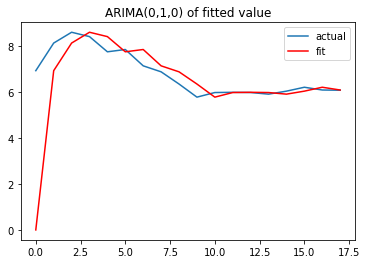

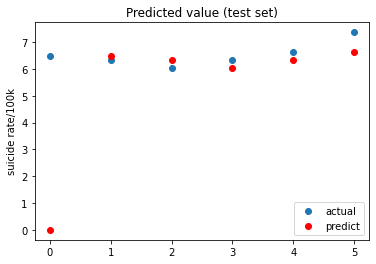

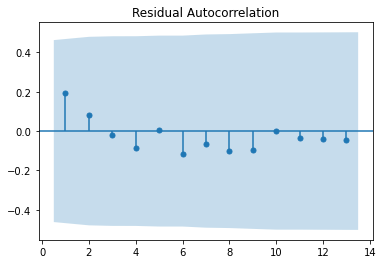

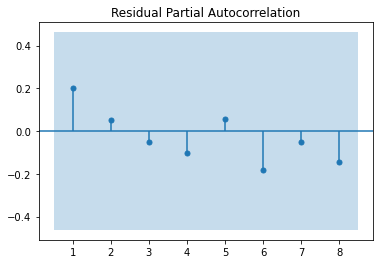

In [159]:
fit_arima(0,1,0)